# A Text Analysis of Franklin D. Roosevelt’s Rhetoric Across His Presidency 

# Alex Domingo 

# Imports


In [2]:
import os
import pandas as pd
import numpy as np
import nltk
import pprint
import matplotlib.pyplot as plt  

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import models
from gensim import corpora
from gensim import similarities
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from collections import defaultdict
from collections import Counter
import textstat

import pyLDAvis
import pyLDAvis.gensim_models

STOPLIST = list(nltk.corpus.stopwords.words('english'))
np.random.seed(5643)
#pd.set_option('display.max_colwidth', 50)

# Preprocessing

In [3]:
text_data = []
path_to_txt_files_no_year = "C:/Users/alexe/Documents/EPSY 5643/Research/FDR Speeches"
files = os.listdir(path_to_txt_files_no_year)

for year in range(1933, 1946):
    folder_path = os.path.join(path_to_txt_files_no_year, str(year))
    files_in_year = os.listdir(folder_path)
    
    for filename in files_in_year:
        file_path = os.path.join(folder_path, filename)
        if ".txt" in filename:
            with open(file_path, "r", encoding="latin-1") as file:
                text = file.read()
                text_data.append({
                    "year": year,
                    "filename": filename[:-4],
                    "text": text
                })
df = pd.DataFrame(text_data)
df = df.set_index("filename")
df.sample()

,year,text
filename,,
Address to Congress 1945,1945,I hope that you will pardon me for this unusua...


In [3]:
def process_text(
    text: str,
    lower_case: bool = True,
    remove_punct: bool = True,
    remove_stopwords: bool = False,
    lemma: bool = False,
    string_or_list: str = "str",
):
    tokens = nltk.word_tokenize(text)
    if lower_case:
        tokens = [token.lower() if token.isalpha() else token for token in tokens]
    if remove_punct:
        tokens = [token for token in tokens if token.isalpha()]
    if remove_stopwords:
        tokens = [token for token in tokens if not token in STOPLIST]
    if lemma:
        tokens = [nltk.wordnet.WordNetLemmatizer().lemmatize(token) for token in tokens]
    if string_or_list != "list":
        doc = " ".join(tokens)
    else:
        doc = tokens

    return doc

In [4]:
df["clean_tokens"] = df.text.apply(process_text, remove_stopwords = True, lemma = True, string_or_list = "list")
df.sample()

,year,text,clean_tokens
filename,,,
Fourth Inaugural Address,1945,"Mr. Chief Justice, Mr. Vice President, my frie...","[chief, justice, vice, president, friend, unde..."


In [5]:
df["clean_string"] = df.text.apply(process_text, remove_stopwords = True, lemma = True, string_or_list = "string")
df.sample()

,year,text,clean_tokens,clean_string
filename,,,,
On Lend Lease,1941,This dinner of the White House Correspondents'...,"[dinner, white, house, correspondent, associat...",dinner white house correspondent association u...


In [6]:
firstterm = df[(df["year"] >= 1933) & (df["year"] <= 1936)]
secondterm = df[(df["year"] >= 1937) & (df["year"] <= 1940)]
thirdterm = df[(df["year"] >= 1941) & (df["year"] <= 1945)]

In [7]:
allfirst = " ".join(firstterm['text'])
allsecond = " ".join(secondterm['text'])
allthird = " ".join(thirdterm['text'])

In [9]:
print(len(firstterm), len(secondterm), len(thirdterm))

14 17 27


# Sentiment Analysis | nltk.sentiment

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [11]:
def calculate_positive_sentiment(text):
    positive = sentiment_analyzer.polarity_scores(text)["pos"]
    return positive
def calculate_negative_sentiment(text):
    negative = sentiment_analyzer.polarity_scores(text)["neg"]
    return negative
def calculate_neutral_sentiment(text):
    neutral = sentiment_analyzer.polarity_scores(text)["neu"]
    return neutral

In [12]:
df["negative_sentiment"] = df.text.apply(calculate_negative_sentiment)
df["positive_sentiment"] = df.text.apply(calculate_positive_sentiment)
df["neutral_sentiment"] = df.text.apply(calculate_neutral_sentiment)

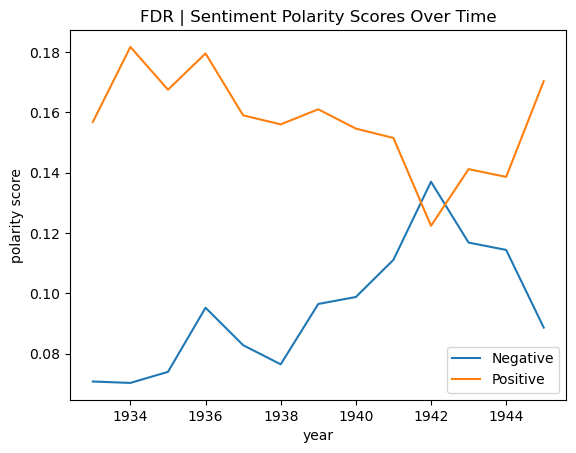

In [13]:
yearly_sentiment = df.groupby("year")[["negative_sentiment", "positive_sentiment", "neutral_sentiment"]].mean()

plt.plot(yearly_sentiment.index, yearly_sentiment.negative_sentiment, label = "Negative")
plt.plot(yearly_sentiment.index, yearly_sentiment.positive_sentiment, label = "Positive")

plt.xlabel('year')
plt.ylabel('polarity score')
plt.title('FDR | Sentiment Polarity Scores Over Time')
plt.legend()

plt.show()

# Ngrams| Gensim

In [14]:
docs_list = list(df.clean_tokens)

In [15]:
from gensim.models.phrases import Phrases, Phraser

## SETTING  BIGRAM min_count in corpus 10

In [16]:
import gensim.models.phrases as phrases
from gensim.models.phrases import Phrases, Phraser
bigram_model = Phrases(docs_list, min_count=10, delimiter = "_", connector_words=phrases.ENGLISH_CONNECTOR_WORDS)
bigram_phraser = Phraser(bigram_model)

def replace_bigrams_with_phrases(token_list):
    return bigram_phraser[token_list]

# Apply to your DataFrame
df["tokens_phrases"] = df.clean_tokens.apply(replace_bigrams_with_phrases)

# Update your docs list
docs_list = list(df.tokens_phrases)

#Count
bigrams_found = Counter()

for doc in docs_list:
    for token in bigram_phraser[doc]:
        if "_" in token:
            bigrams_found[token] += 1

# Print unique bigrams
for bigram, count in bigrams_found.most_common(10):  #most_common from collections package allows you to toggle the top ten like I did here
    print(f"{bigram}: {count}")

united_state: 261
american_people: 121
men_woman: 75
united_nation: 71
armed_force: 59
year_ago: 58
billion_dollar: 48
let_u: 45
purchasing_power: 41
army_navy: 33


## SETTING Trigram min_count 3

In [17]:
trigram_model = Phrases(bigram_phraser[docs_list], min_count=3)
trigram_phraser = Phraser(trigram_model)

def replace_trigrams_with_phrases(token_list):
    return trigram_phraser[token_list]
    
df["tokens_trigrams"] = df.tokens_phrases.apply(replace_trigrams_with_phrases)

docs_list = list(df.tokens_trigrams)
#Count
trigrams_found = Counter()

for doc in docs_list:
    for token in trigram_phraser[doc]:
        if token.count("_") ==2:
            trigrams_found[token] += 1

# Print unique bigrams
for trigram, count in trigrams_found.most_common(10):  #most_common from collections package allows you to toggle the top ten like I did here
    print(f"{trigram}: {count}")

people_united_state: 29
government_united_state: 20
president_united_state: 16
soldier_sailor_marine: 15
united_state_america: 13
every_man_woman: 12
executive_branch_government: 9
congress_united_state: 9
germany_italy_japan: 9
men_woman_child: 8


# Topic Modeling with chosen N grams

# Model Settings

In [18]:
gensim_dictionary = Dictionary(df.tokens_trigrams)
gensim_dictionary.filter_extremes(no_below=12, no_above=0.65)

corpus = []
for doc in df.tokens_trigrams:
    corpus.append(gensim_dictionary.doc2bow(doc))
    
gensim_dictionary[0]
word_id = gensim_dictionary.id2token

NUM_TOPICS = 12
RANDOM_STATE = 5643

lda_model = LdaModel(
    corpus=corpus,
    id2word=word_id,
    random_state = RANDOM_STATE,
    num_topics=NUM_TOPICS,
)

lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, gensim_dictionary)
pyLDAvis.display(lda_vis)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


# As LDAvis sorts topic based on prevalence (proportion) in the corpus, need to sort the topics from lda_model.get_document_topics

In [19]:
list_of_topic_tables = []
for topic in lda_model.show_topics(
    num_topics=-1, num_words=5, formatted=False
):
    list_of_topic_tables.append(
        pd.DataFrame(
            topic[1],
            columns=["Word" + "_" + str(topic[0]), "Prob" + "_" + str(topic[0])],
        )
    )

In [20]:
bigdf = pd.concat(list_of_topic_tables, axis=1)
bigdf

,Word_0,Prob_0,Word_1,Prob_1,Word_2,Prob_2,Word_3,Prob_3,Word_4,Prob_4,...,Word_7,Prob_7,Word_8,Prob_8,Word_9,Prob_9,Word_10,Prob_10,Word_11,Prob_11
0,production,0.008227,worker,0.005742,democracy,0.007689,program,0.006220,attack,0.006013,...,bank,0.006777,democracy,0.006551,plan,0.004416,enemy,0.005257,attack,0.004850
1,plan,0.005709,plan,0.005177,production,0.005604,production,0.005677,democracy,0.005560,...,japanese,0.006715,production,0.005128,democracy,0.004206,program,0.005145,enemy,0.004736
2,attack,0.005536,production,0.004774,worker,0.004825,enemy,0.005168,production,0.005100,...,program,0.005891,freedom,0.004480,money,0.004089,democracy,0.004820,plan,0.004654
3,enemy,0.004491,defense,0.004757,price,0.004697,industry,0.005146,defense,0.005030,...,enemy,0.005817,plan,0.004269,program,0.003922,attack,0.004814,democracy,0.004510
4,fighting,0.004354,democracy,0.004463,industry,0.004644,defense,0.004770,germany,0.004732,...,worker,0.004762,program,0.004172,hand,0.003899,freedom,0.004728,nazi,0.004483


# Looking at the topics with the most prevalence as determined by ldavis

In [23]:
lda_model.get_document_topics(corpus[0], minimum_probability=0)

[(0, 0.00026628),
 (1, 0.0002662813),
 (2, 0.00026627994),
 (3, 0.00026628026),
 (4, 0.08976906),
 (5, 0.00026628133),
 (6, 0.9004114),
 (7, 0.007422975),
 (8, 0.00026627866),
 (9, 0.00026628107),
 (10, 0.0002662792),
 (11, 0.00026628075)]

In [24]:
topic_probs = []
for document in corpus:
    document_topics = []
    for topic_prob in lda_model.get_document_topics(document, minimum_probability=0):
        document_topics.append(topic_prob[1])
    topic_probs.append(document_topics)
topic_probs[0]

[0.00026628,
 0.00026628133,
 0.00026627997,
 0.0002662803,
 0.08112239,
 0.00026628136,
 0.9158935,
 0.00058752106,
 0.0002662787,
 0.0002662811,
 0.0002662792,
 0.00026628078]

In [25]:
topic_probs_df = pd.DataFrame(topic_probs)
topic_probs_df.sample()

,0,1,2,3,4,5,6,7,8,9,10,11
36,0.000165,0.297292,0.213993,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.487226


In [26]:
doc_topics = (
    df.reset_index()
    .merge(topic_probs_df, left_index=True, right_index=True)
)
doc_topics.sample()

,filename,year,text,clean_tokens,clean_string,negative_sentiment,positive_sentiment,neutral_sentiment,tokens_phrases,tokens_trigrams,...,2,3,4,5,6,7,8,9,10,11
26,Democratic National Convention 1940,1940,Members of the Convention-my friends:\nIt is v...,"[member, friend, late, felt, would, rather, sp...",member friend late felt would rather speak wai...,0.081,0.168,0.751,"[member, friend, late, felt, would, rather, sp...","[member, friend, late, felt, would, rather, sp...",...,0.011539,0.000132,0.04581,0.002116,0.013806,0.000132,0.000132,0.391438,0.000132,0.179119


In [27]:
doc_topics_clean = doc_topics.iloc[:,[0, 1, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

In [28]:
yearly_prev = doc_topics_clean.groupby("year")[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11]].mean()

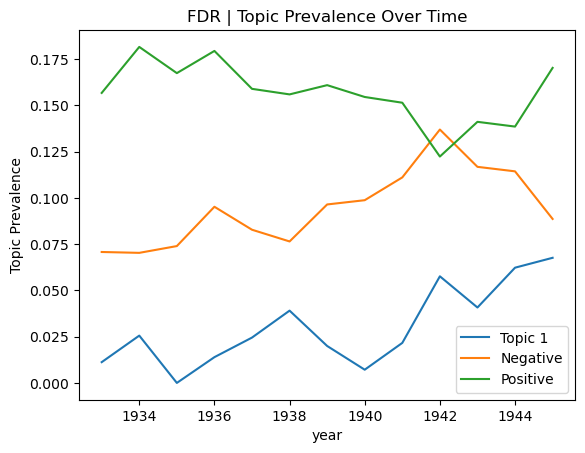

[('attack', 0.0048497473),
 ('enemy', 0.004736241),
 ('plan', 0.0046535335),
 ('democracy', 0.0045096464),
 ('nazi', 0.004483308),
 ('production', 0.0043578018),
 ('program', 0.004177996),
 ('last', 0.004118979),
 ('price', 0.0041108835),
 ('japanese', 0.004050056)]

In [79]:
plt.plot(yearly_prev.index, (yearly_prev[11])/10, label = "Topic 1")
plt.plot(yearly_sentiment.index, yearly_sentiment.negative_sentiment, label = "Negative")
plt.plot(yearly_sentiment.index, yearly_sentiment.positive_sentiment, label = "Positive")


plt.xlabel('year')
plt.ylabel('Topic Prevalence')
plt.title('FDR | Topic Prevalence Over Time')
plt.legend()

plt.show()

top_words_topic_11 = lda_model.show_topic(11, topn=10)  
top_words_topic_11

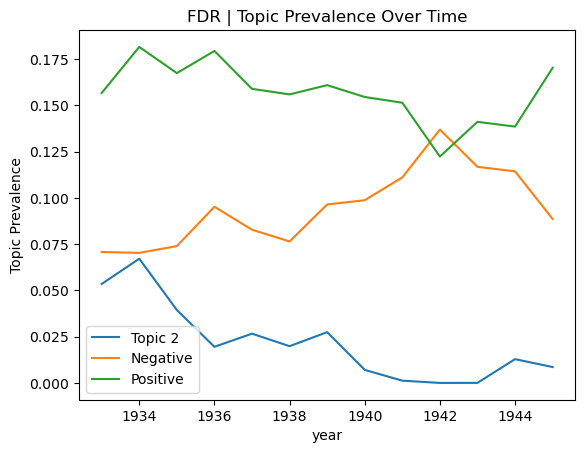

[('bank', 0.0065632146),
 ('industry', 0.0059199645),
 ('freedom', 0.0048762406),
 ('attack', 0.004542384),
 ('three', 0.004240343),
 ('plan', 0.0040901555),
 ('democracy', 0.0039778906),
 ('ship', 0.0038765694),
 ('program', 0.0038748954),
 ('act', 0.0038644578)]

In [82]:
plt.plot(yearly_prev.index, (yearly_prev[6])/10, label = "Topic 2 ")
plt.plot(yearly_sentiment.index, yearly_sentiment.negative_sentiment, label = "Negative")
plt.plot(yearly_sentiment.index, yearly_sentiment.positive_sentiment, label = "Positive")


plt.xlabel('year')
plt.ylabel('Topic Prevalence')
plt.title('FDR | Topic Prevalence Over Time')
plt.legend()

plt.show()
top_words_topic_6 = lda_model.show_topic(6, topn=10)  
top_words_topic_6

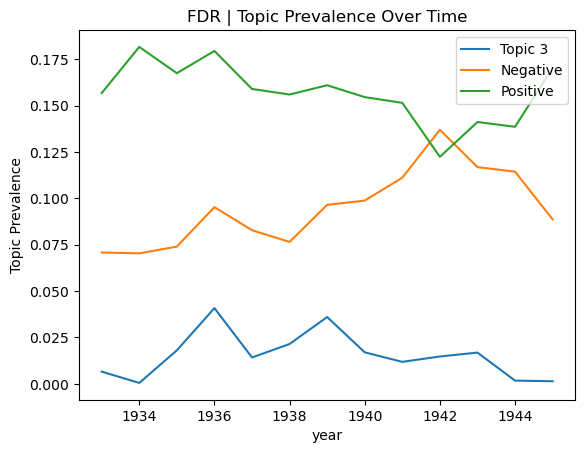

In [81]:
plt.plot(yearly_prev.index, (yearly_prev[1])/10, label = "Topic 3")
plt.plot(yearly_sentiment.index, yearly_sentiment.negative_sentiment, label = "Negative")
plt.plot(yearly_sentiment.index, yearly_sentiment.positive_sentiment, label = "Positive")


plt.xlabel('year')
plt.ylabel('Topic Prevalence')
plt.title('FDR | Topic Prevalence Over Time')
plt.legend()

plt.show()

top_words_topic_1 = lda_model.show_topic(1, topn=10)  
top_words_topic_1

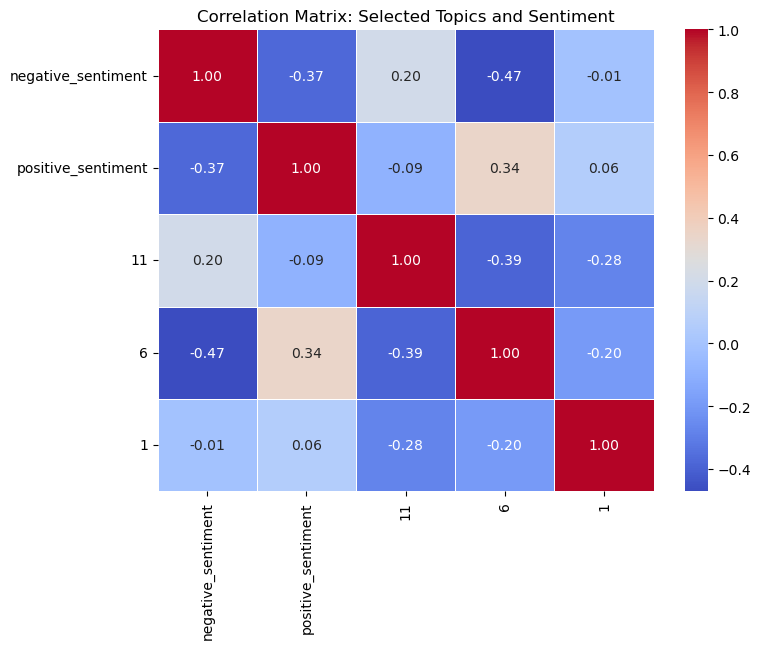

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_correlate = ['negative_sentiment', 'positive_sentiment', 11, 6, 1]

correlation_matrix = doc_topics_clean[columns_to_correlate].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix: Selected Topics and Sentiment")
plt.show()


In [35]:
TOPN = 10

In [36]:
lda_model.show_topic(0, topn=TOPN)

[('production', 0.008226647),
 ('plan', 0.005708861),
 ('attack', 0.0055359625),
 ('enemy', 0.0044905753),
 ('fighting', 0.0043544075),
 ('task', 0.004277305),
 ('defense', 0.0042508403),
 ('japanese', 0.004164322),
 ('program', 0.0040454506),
 ('military', 0.0038625782)]

In [37]:
topn_terms = [term for term, _ in lda_model.show_topic(0, topn=TOPN)]
topn_terms

['production',
 'plan',
 'attack',
 'enemy',
 'fighting',
 'task',
 'defense',
 'japanese',
 'program',
 'military']

In [38]:
CoherenceModel(topics=[topn_terms], corpus=corpus, dictionary=gensim_dictionary, coherence='u_mass', topn = TOPN).get_coherence()

-0.5332666766460992

In [39]:
range(lda_model.num_topics)

range(0, 12)

In [40]:
topic_coherence_scores = []
for n in range(lda_model.num_topics):
    topn_terms = [term for term, _ in lda_model.show_topic(n, topn=TOPN)]
    coherence = CoherenceModel(topics=[topn_terms], corpus=corpus, dictionary=gensim_dictionary, coherence='u_mass', topn = TOPN)
    score = coherence.get_coherence()
    topic_coherence_scores.append(score)
topic_coherence_scores

[-0.5332666766460992,
 -0.43137121833888176,
 -0.5445697303003697,
 -0.4798646935789164,
 -0.5819559102260461,
 -0.41902211783092674,
 -0.5280731731265579,
 -0.6117168754891269,
 -0.5707710600800673,
 -0.46474498458138963,
 -0.47584628699279086,
 -0.6386232737486617]

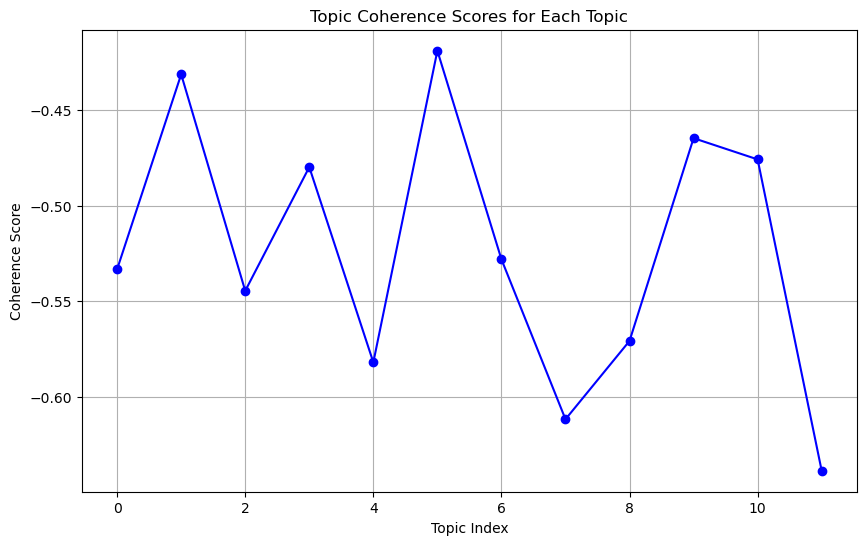

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(topic_coherence_scores)), topic_coherence_scores, marker='o', linestyle='-', color='b')
plt.title('Topic Coherence Scores for Each Topic')
plt.xlabel('Topic Index')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()

In [50]:
firstterm = df[(df["year"] >= 1933) & (df["year"] <= 1936)]
secondterm = df[(df["year"] >= 1937) & (df["year"] <= 1940)]
thirdterm = df[(df["year"] >= 1941) & (df["year"] <= 1945)]

In [55]:
vec = TfidfVectorizer(lowercase=True, strip_accents="ascii", stop_words="english")


In [62]:
X = vec.fit_transform(firstterm.text)
matrix_X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out(), index=firstterm.index)

Y = vec.fit_transform(secondterm.text)
matrix_Y = pd.DataFrame(Y.toarray(), columns=vec.get_feature_names_out(), index=secondterm.index)

Z = vec.fit_transform(thirdterm.text)
matrix_Z = pd.DataFrame(Z.toarray(), columns=vec.get_feature_names_out(), index=thirdterm.index)

All = vec.fit_transform(df.text)
matrix_All = pd.DataFrame(All.toarray(), columns=vec.get_feature_names_out(), index=df.index)

In [57]:
matrix_X.sum().sort_values(ascending = False).head(10)

people        1.619163
government    1.548170
work          1.100262
national      0.942731
great         0.910309
new           0.853117
country       0.776778
time          0.770576
public        0.760097
banks         0.753976
dtype: float64

In [58]:
matrix_Y.sum().sort_values(ascending = False).head(10)

government    2.345567
people        1.694675
nation        1.542251
world         1.525372
peace         1.280295
congress      1.087526
new           1.069309
states        1.058432
american      1.052301
united        1.035918
dtype: float64

In [59]:
matrix_Z.sum().sort_values(ascending = False).head(10)

war         4.382968
world       2.377456
people      2.375778
american    2.164981
united      2.110704
men         1.821829
forces      1.535865
peace       1.509503
nation      1.460255
nations     1.449230
dtype: float64

In [63]:
matrix_All.sum().sort_values(ascending = False).head(10)

war           5.629163
people        4.972897
government    4.401279
world         4.228245
nation        3.355002
american      3.353493
united        3.162554
peace         3.073335
states        2.731742
men           2.709116
dtype: float64

In [67]:
topic_probs_df.sum(axis=0).sort_values(ascending=False).head(5)

11    17.889481
6     10.561210
1      8.433296
4      8.142133
0      3.824689
dtype: float32

In [69]:
print(len(firstterm), len(secondterm), len(thirdterm))

14 17 27


In [73]:
topic_probs_df_first = topic_probs_df[0:14]
topic_probs_df_second = topic_probs_df[14:31]  
topic_probs_df_third = topic_probs_df[31:58]  

In [77]:
topic_probs_df_first.sum(axis=0).sort_values(ascending=False).head(5) 

6     6.261618
1     2.335712
11    1.888062
9     1.254545
3     0.865520
dtype: float32

In [75]:
topic_probs_df_second.sum(axis=0).sort_values(ascending=False).head(5)

11    3.793191
4     3.530784
6     3.295822
1     3.278839
3     1.038697
dtype: float32

In [76]:
topic_probs_df_third.sum(axis=0).sort_values(ascending=False).head(5)

11    12.208227
4      4.000447
0      3.317215
1      2.818745
2      1.600232
dtype: float32

In [93]:
Top3prevtopics = pd.concat([list_of_topic_tables[11], list_of_topic_tables[6], list_of_topic_tables[1]], axis=1)
Top3prevtopics.columns = ["Topic 1 Wartime", "prob", "Topic 2 bank/freedom", "prob", "Topic 3 mobilization/unity", "prob",]
Top3prevtopics

,Topic 1 Wartime,prob,Topic 2 bank/freedom,prob,Topic 3 mobilization/unity,prob
0,attack,0.004850,bank,0.006563,worker,0.005742
1,enemy,0.004736,industry,0.005920,plan,0.005177
2,plan,0.004654,freedom,0.004876,production,0.004774
3,democracy,0.004510,attack,0.004542,defense,0.004757
4,nazi,0.004483,three,0.004240,democracy,0.004463
